### Background

we do some assumtion to help get the certain number as a target like percentage of customer churn to reduce from 20% to 5%. 

we will use "recall" as the metric to evaluate the model because we want to reduce the number of customer churn. Eventhough we are still considering the "precision" as well.

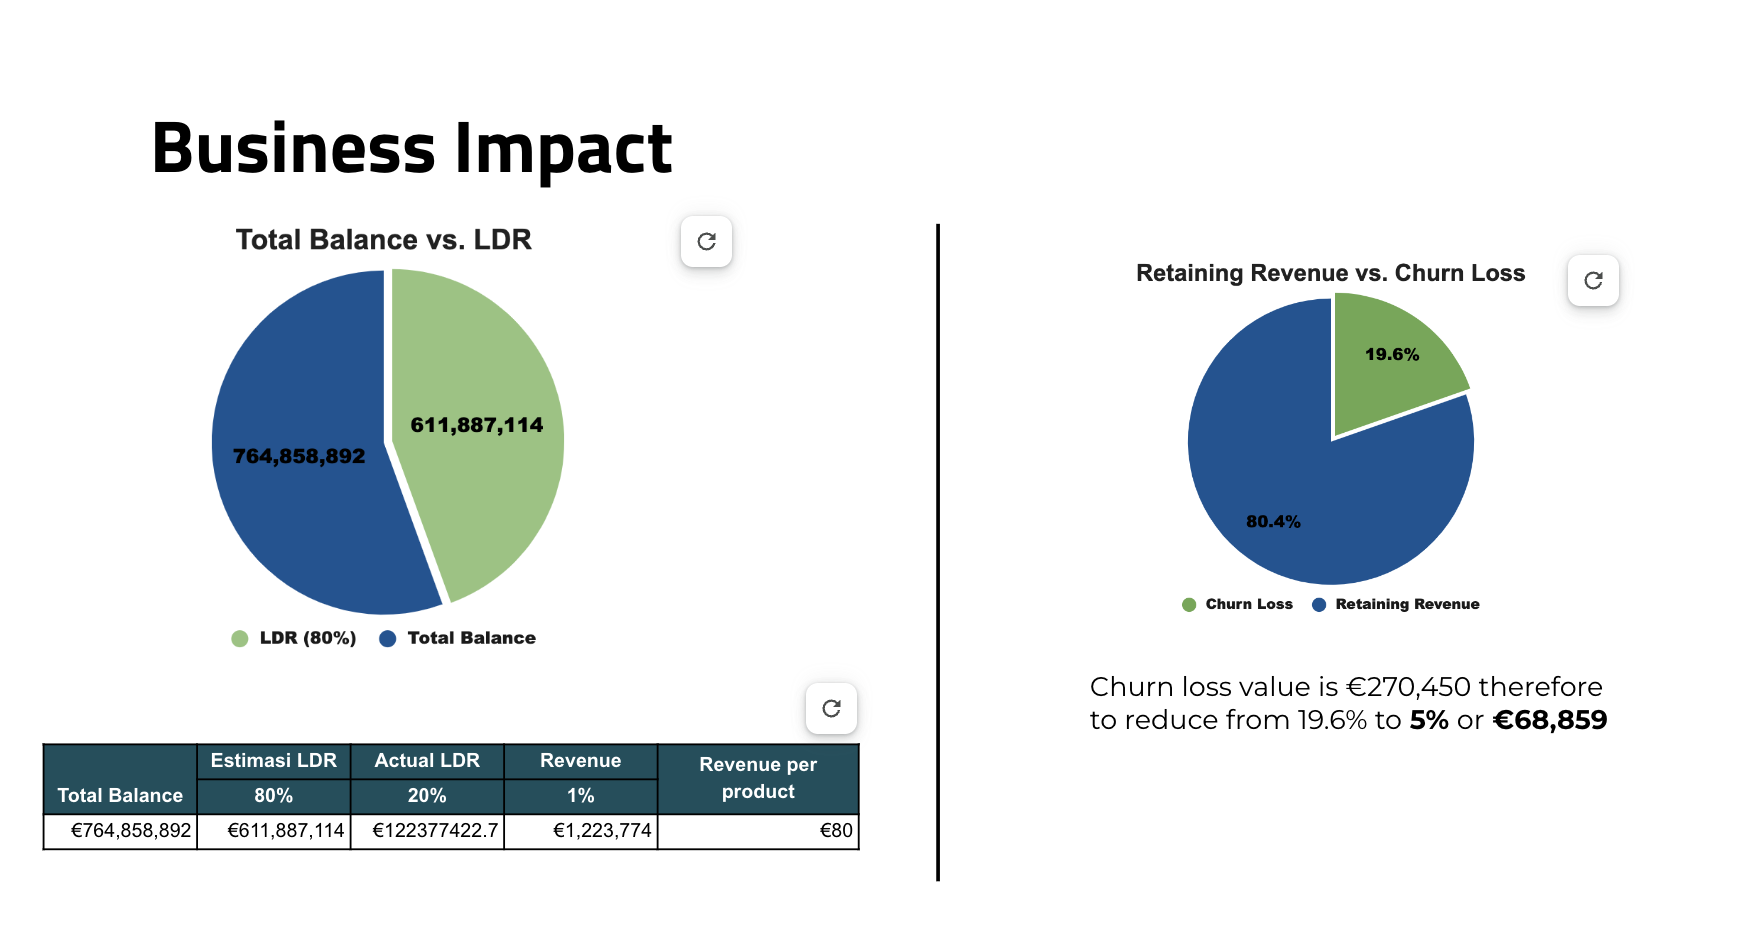

### Imports libraries and Read data

In [530]:
import warnings
warnings.filterwarnings('ignore')

In [531]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency

In [532]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler

from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imbalanced_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [533]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [534]:
random_state = 42  # For reproducibility
sns.set_theme(style="darkgrid", font_scale=1, rc={"axes.titlesize":18}, palette="Set1")


In [535]:
url = "https://raw.githubusercontent.com/sagnikghoshcr7/Bank-Customer-Churn-Prediction/master/Churn_Modelling.csv"
df = pd.read_csv(url, header=0, index_col=0)


In [536]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [537]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


There is no null value in the dataset.

#### check duplicates data 

In [538]:
df.duplicated().any()

False

There is no duplicate data in the dataset.

### Exploratory Data Analysis (EDA) & Feature Preprocessing

In [539]:
df.drop(columns=["CustomerId","Surname"], inplace = True)

In [540]:
categorical = ["Geography", "Gender", "Tenure", "NumOfProducts", "HasCrCard", "IsActiveMember"]
numerical = ["CreditScore", "Age", "Balance", "EstimatedSalary"]

In [541]:
df["Exited"] = df["Exited"].astype("category")

In [542]:
for i in categorical:
    df[i] = df[i].astype("category")

In [543]:
for i in numerical:
    df[i] = df[i].astype("float64")

In [544]:
df_num = df.select_dtypes(include=np.number)

#### Outlier Treatment

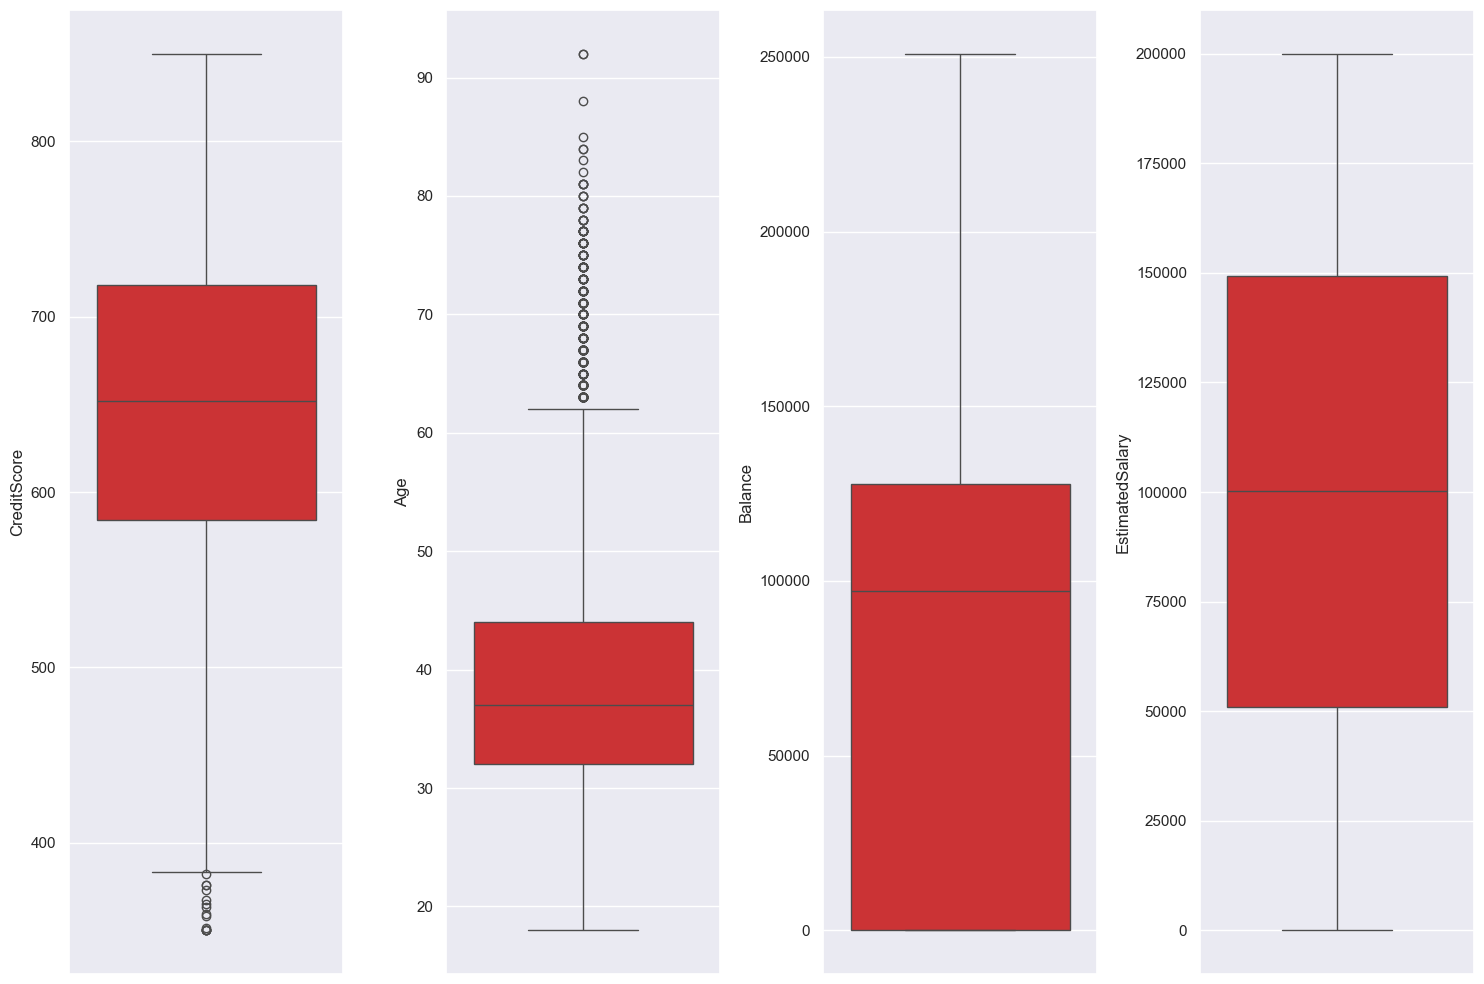

In [545]:
plt.figure (figsize=(15,10))

for i in range(len(numerical)):
    plt.subplot(1,len(numerical),i+1)
    sns.boxplot(data = df, y=df_num[numerical[i]])
    plt.tight_layout()

Credit Score has outliers. We will remove them using z-score.
Age looks some data is outliear but we will not remove them as it is possible that some customers are old.

In [546]:
zscores = np.abs(stats.zscore(df["CreditScore"]))
filter = zscores < 3
df_clean = df[filter]
print("number of outliers removed:", zscores.shape[0] - filter.sum())

number of outliers removed: 8


#### Split the data into train and test

In [547]:
df_train, df_test = train_test_split(df_clean, test_size=0.2, random_state=random_state)

In [548]:
df_train.shape, df_test.shape

((7993, 11), (1999, 11))

#### Exploratory Data Analysis ####

**In this EDA I would like to explore the following questions:**

1. What is the distribution of the target variable?
2. which gender has the highest churn rate?
3. how is the distributy customer based on geography?
4. with activity of customers that effect the churn rate? (Creditscore, isactivemember, balance, number of products, tenure)
5. which the most important features that affect the target variable?

##### Target variable #####

In [549]:
Exit_label = {1:"Exited", 0:"Retained"}
custom_palette = {'1': 'red', '0': 'blue'}
custom_palette2 = {1: 'red', 0: 'blue'} # for the legend and hue


In [550]:
def add_values_labels(ax):
    total = sum([p.get_height() for p in ax.patches])
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100*p.get_height()/total)  # format as percentage
        ax.annotate(percentage, (p.get_x()+p.get_width()/2.,p.get_height()), ha = "center", va="center", xytext=(0,5), fontsize=12, color="black",textcoords='offset points')

In [551]:
df["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Text(0.5, 1.0, 'Distribution of Exited and Retained Customers')

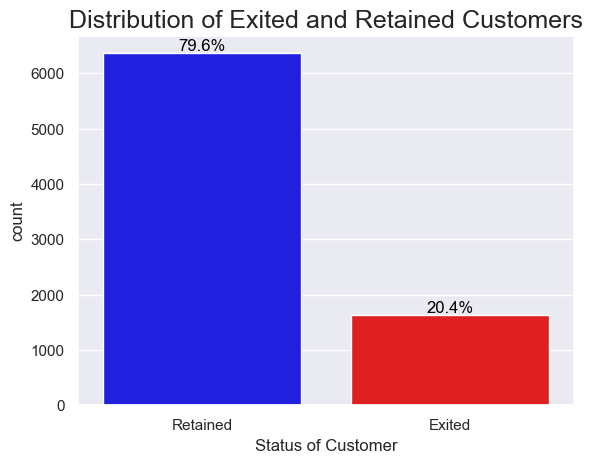

In [552]:

ax = sns.countplot(data=df_train, x="Exited", palette=custom_palette)
add_values_labels(ax)
ax.set_xticklabels(reversed(Exit_label.values()))
ax.set_xlabel("Status of Customer")
ax.set_title("Distribution of Exited and Retained Customers")



From distribution above we can see that the data is imbalanced which is number of customer who retained is higher that churn with the comparison is around 80% : 20% respectively

#### Numeric Features

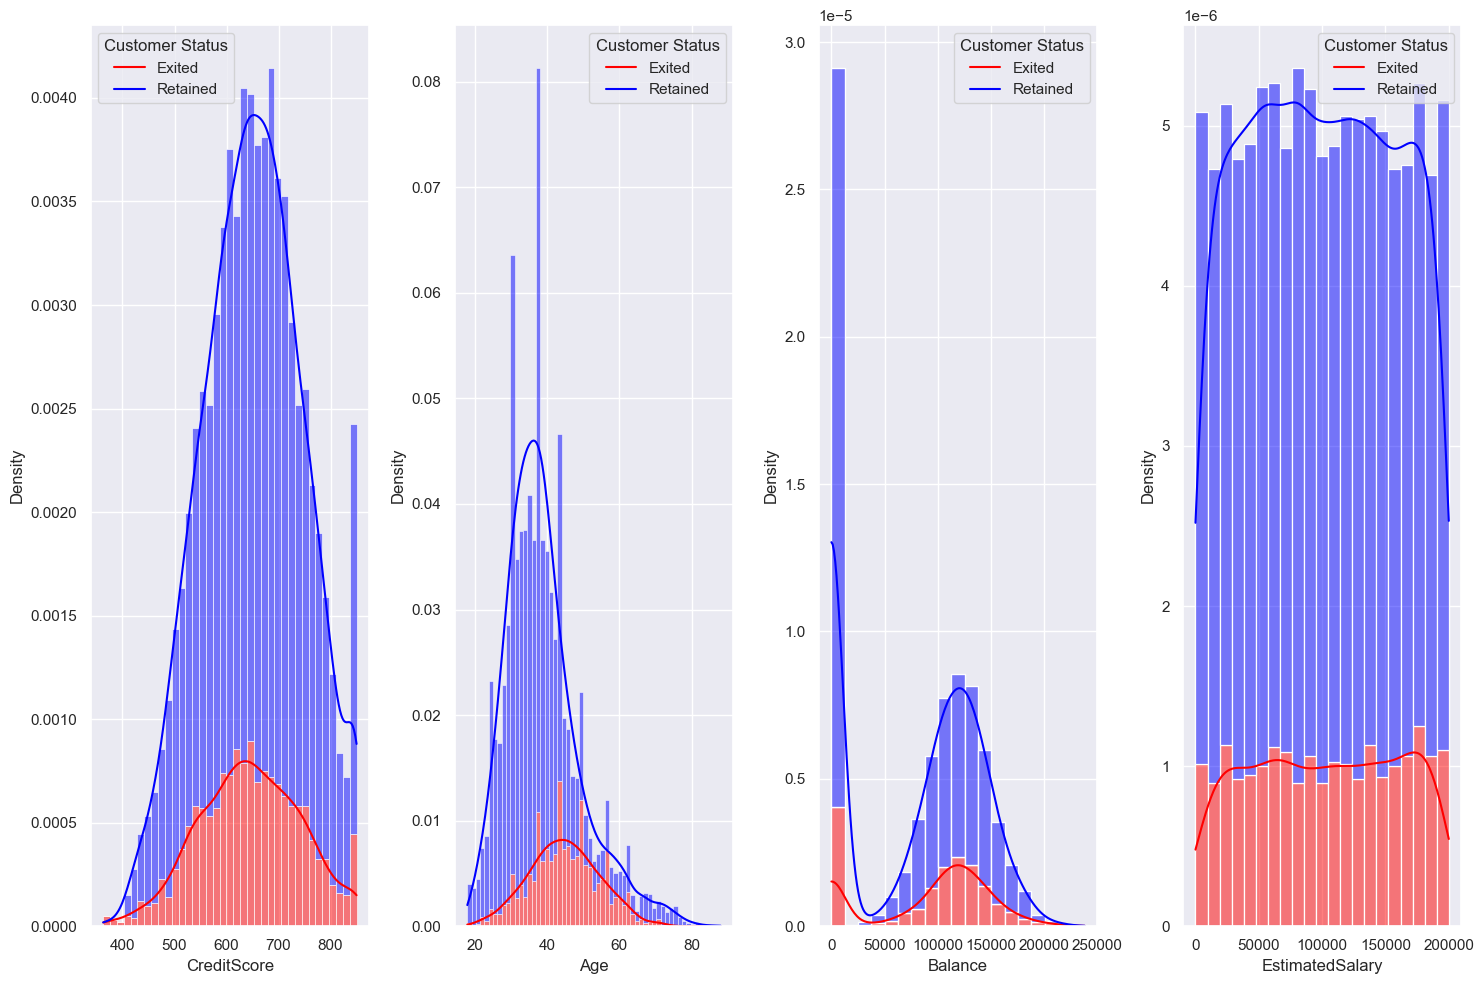

In [553]:
plt.figure(figsize=(15,10))

for i in range(len(numerical)):
    plt.subplot(1,len(numerical),i+1)
    sns.histplot(data=df_train, x=numerical[i], kde=True, hue="Exited", stat="density", palette=custom_palette2, alpha=0.5,multiple="stack")
    plt.legend(title="Customer Status", labels=Exit_label.values())
    plt.tight_layout()


for distribution plot we can see if there are features have skewness. We need to do some transformation to make the data more normal distribution.
if we see from peak of distribution from these features. We can see feature "Age" has different peak distribution between "Exited" and "Retained" that means that features importance to the status of customer 

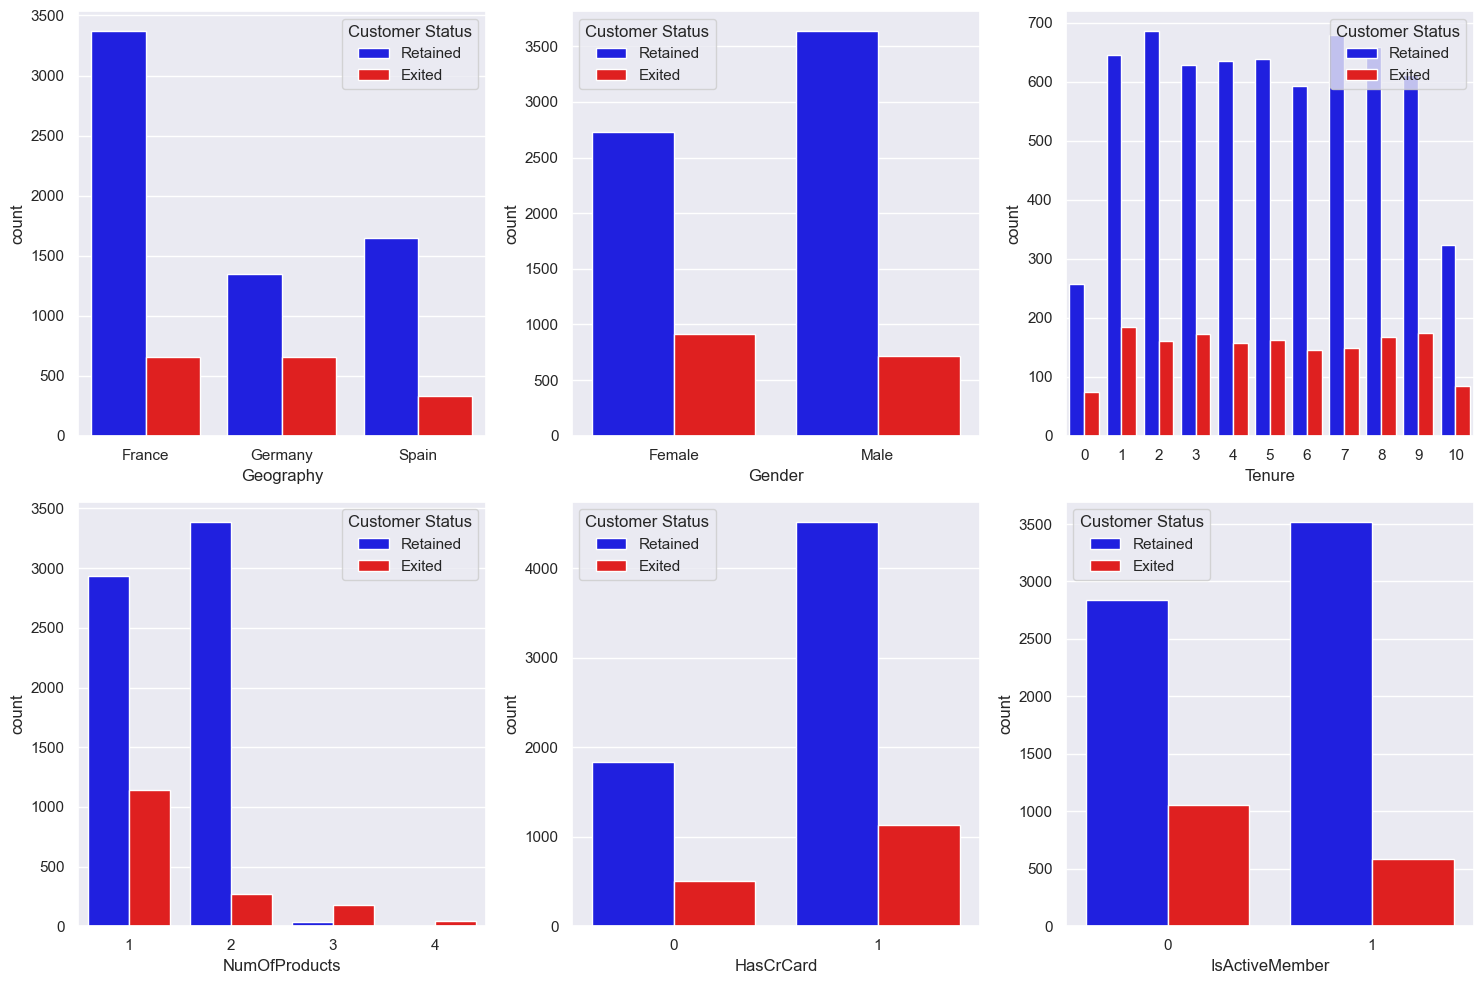

In [554]:
plt.figure(figsize=(15,10))

for i in range (len(categorical)):
    plt.subplot(2,3,i+1)
    sns.countplot(data=df_train, x=categorical[i], hue="Exited", palette=custom_palette2)
    plt.legend(title="Customer Status", labels=list(Exit_label.values())[::-1])
    plt.tight_layout()

- **Geography**

If we see from the distribution of the customers, we can see that most of the customers are from France, followed by Germany and Spain. But if we see the distribution of the customers who exited, we can see that most of the customers who exited are from Germany, followed by France and Spain. So, we can say that the customers from Germany are more likely to exit.


- **Gender**

The most customer is male then female is more likely to exit.  


##### The customer behaviour #####

- **Tenure**

it is difficult to say anything from the tenure distribution. But we can see that the customers who exited are more likely to have a tenure of 1 year.

- **NumOfProducts**

the most customer have 1 product and the most customer who exited have 1 product. But if we see based on churn rate the customer with higher number of product is sligthly churn

- **HasCrCard**

the most customer have credit card and the customer who does not have credit card is more likely to exit.

- **IsActiveMember**

the most customer is active and the customer who is not active is more likely to exit.

- **Balance**

it is quite same between the distribution of customer retained and churn which the balance is around 10K-15K 

### Feature Engineering

#### Numerical Features

<AxesSubplot: >

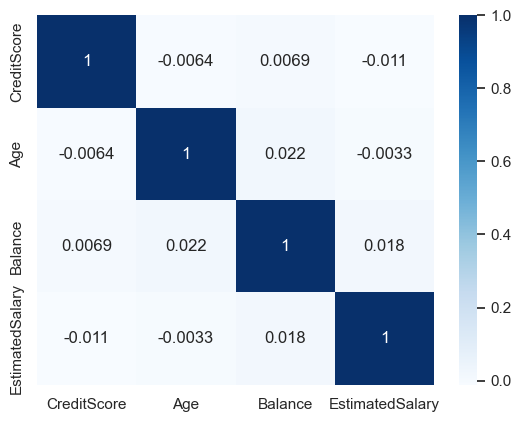

In [555]:
sns.heatmap(df_train[numerical].corr(), annot =True, cmap="Blues")

there is no significant correlation between the numerical features or intercorrelation between them

#### Categorical Features

In [556]:
df_train[categorical].head()

,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember
RowNumber,,,,,,
5855,France,Female,5,2,1,1
169,Spain,Female,2,2,1,0
8961,Germany,Female,8,1,1,0
7487,France,Male,8,2,0,0
9529,France,Male,9,1,1,0


One of methods to feature selection in particular categorical data is to use chi-square test. The chi-square test is used to determine whether there is a significant difference between the expected frequencies and the observed frequencies in one or more categories.

we will do one hot encoding for the categorical variablesfor "Geography" and "Gender"

In [557]:
chi2_value = []
p_value = []

for col in categorical:
    category_data = pd.crosstab(df_train[col],df_train["Exited"])
    chi2, p, dof, expected = chi2_contingency(category_data.values)
    chi2_value.append(chi2)
    p_value.append(p)

chi2_test = pd.DataFrame({"Feature":categorical, "Chi2":chi2, "P-Value":p_value})


In [558]:
chi2_test.sort_values(by="P-Value")

,Feature,Chi2,P-Value
3,NumOfProducts,201.184621,1.962586e-263
0,Geography,201.184621,1.040053e-54
5,IsActiveMember,201.184621,1.151662e-45
1,Gender,201.184621,6.347345e-21
4,HasCrCard,201.184621,1.531739e-01
2,Tenure,201.184621,5.435709e-01


Based on chi2 test that focus to p-value. We can see if "HasCrCard" and "Tenure" has a value more than 0.05. It means we will reject null hypothesis or not significant or drop those features

In [559]:
df_train.drop(["HasCrCard", "Tenure"], axis=1, inplace=True)
df_test.drop(["HasCrCard", "Tenure"], axis=1, inplace=True)

### Building Models 

In this process modelling we will use **recall** as main metrics because we want to reduce number of customer who actually churn but we get wrong prediction or False Positive

In [560]:
X_train = df_train.drop(columns=["Exited"])
y_train = df_train["Exited"]

X_test = df_test.drop(columns=["Exited"])
y_test = df_test["Exited"]

In [561]:
scaler = StandardScaler()
minmax = MinMaxScaler()
power = PowerTransformer()
onehot = OneHotEncoder(sparse=False) 

categorical = ["Geography", "Gender", "NumOfProducts", "IsActiveMember"]

def log(x):
    return np.log(x)

log_transformer = FunctionTransformer(func=log)
pass_through = FunctionTransformer(func=lambda x: x)

preprocessor = ColumnTransformer(transformers=[
    ("log", log_transformer, ["Age"]), 
    ("scaler", scaler, ["CreditScore", "EstimatedSalary", "Balance"]),
    ("cat", onehot, categorical),  # Use the updated OneHotEncoder
    # ("pass", pass_through, ["NumOfProducts", "IsActiveMember"]),
])

smote = SMOTE(sampling_strategy=1, random_state=42)

imbalanced_pipeline = imbalanced_pipeline(steps=[
    ("preprocessor", preprocessor),
    ("SMOTE", smote),
]).set_output(transform="pandas")


In [562]:
X_smote, y_smote = imbalanced_pipeline.fit_resample(X_train, y_train)

In [563]:
X_test_transformed = preprocessor.transform(X_test)

In [564]:
X_smote.shape, y_smote.shape

((12720, 15), (12720,))

#### Base Model (Logistic Regression and Naive Bayes)

In [565]:
logreg = LogisticRegression(random_state=random_state)

logreg.fit(X_smote, y_smote)
y_train_pred = logreg.predict(X_smote)
y_pred = logreg.predict(X_test_transformed)


print("### Logistic Regression ###")
print(f"recall score train: {recall_score(y_smote, y_train_pred)}")
print(f"recall score test: {recall_score(y_test, y_pred)}")


### Logistic Regression ###
recall score train: 0.7674528301886793
recall score test: 0.75


In [566]:
gnb = GaussianNB()

gnb.fit(X_smote, y_smote)
y_train_pred = gnb.predict(X_smote)
y_pred = gnb.predict(X_test_transformed)

print("### GaussianNB ###")
print(f"recall score train: {recall_score(y_smote, y_train_pred)}")
print(f"recall score test: {recall_score(y_test, y_pred)}")

### GaussianNB ###
recall score train: 0.13050314465408805
recall score test: 0.14646464646464646


Based on the based model as we can see if we use Logistic Regression we get the best recall score so we can continue to check the several model

#### Standard Model ####

In [567]:
def scoring(key, model):
    result = pd.DataFrame(columns=["classifier","recall_test", "recall_train", "precision_test","accuracy_test"]) 

    recall_train_scores = cross_val_score(model,X_smote, y_smote, cv=5, scoring='recall')

    model.fit(X_smote, y_smote)

    y_pred_test = model.predict(X_test_transformed)

    recall_test = recall_score(y_test, y_pred_test)
    precision_test = precision_score(y_test,y_pred_test)
    accuracy_test = accuracy_score(y_test, y_pred)


    result.loc[key] = [key, recall_test, recall_train_scores.mean(), precision_test, accuracy_test]

    return result

In [568]:
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=random_state),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(random_state=random_state),
    'Gradient Boosting': GradientBoostingClassifier(random_state=random_state),
    'AdaBoost': AdaBoostClassifier(random_state=random_state),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=random_state),
    'XGBoost': XGBClassifier(random_state=random_state)
}


result_df = pd.DataFrame(columns=["classifier", "recall_test", "recall_train", "precision_test", "roc_auc_test", "accuracy_test"])

for key, classifier in classifiers.items():

    score = scoring(key, classifier)

    result_df = pd.concat([result_df, score])

result_df.reset_index(drop=True, inplace=True)

In [569]:
result_df

,classifier,recall_test,recall_train,precision_test,roc_auc_test,accuracy_test
0,Logistic Regression,0.750000,0.767767,0.440653,NaN,0.824412
1,SVM,0.734848,0.802516,0.435629,NaN,0.824412
2,Random Forest,0.606061,0.896069,0.568720,NaN,0.824412
3,Gradient Boosting,0.694444,0.818396,0.519849,NaN,0.824412
4,AdaBoost,0.707071,0.783648,0.469012,NaN,0.824412
5,KNN,0.621212,0.915881,0.375000,NaN,0.824412
6,Naive Bayes,0.146465,0.130346,0.816901,NaN,0.824412
7,Decision Tree,0.530303,0.809748,0.426829,NaN,0.824412
8,XGBoost,0.580808,0.844025,0.585242,NaN,0.824412


##### Voting Classifier W/ Default Parameters

In [570]:
voting_model = VotingClassifier(estimators=[
    ('svm', SVC(random_state=42)),
    ("logreg", LogisticRegression(random_state=42)),
    ('adaboost', AdaBoostClassifier(random_state=42)),
], voting="hard")

# Scoring

scoring("voting", voting_model)


,classifier,recall_test,recall_train,precision_test,accuracy_test
voting,voting,0.747475,0.783019,0.46395,0.824412


#### Hyperparameter Tuning ####

to improve the results of the model, we will use hyperparameter tuning

##### Logistic Regression ###

In [571]:

logreg = LogisticRegression(random_state=42)

logreg_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [100, 200, 300]
}

logreg_grid = GridSearchCV(logreg, logreg_params, cv=5, scoring='recall')

logreg_grid.fit(X_smote, y_smote)

logreg_best = logreg_grid.best_estimator_

scoring("logreg_params", logreg_best)

logreg_grid.fit(X_smote, y_smote)

logreg_best = logreg_grid.best_estimator_

scoring("logreg_params", logreg_best)


,classifier,recall_test,recall_train,precision_test,accuracy_test
logreg_params,logreg_params,0.757576,0.780189,0.418994,0.824412


In [572]:
svm = SVC()

svm_params = {
    'C': [0.1, 10, 100],
    'gamma': ['scale', 'auto']
}



svm_grid = RandomizedSearchCV(svm, svm_params, cv=5, scoring='recall', n_iter=10, random_state=random_state)


svm_grid.fit(X_smote, y_smote)

svm_best = svm_grid.best_estimator_


scoring("svm_params", svm_best)


,classifier,recall_test,recall_train,precision_test,accuracy_test
svm_params,svm_params,0.70202,0.835063,0.469595,0.824412


In [573]:


ada_params = {
   'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

ada_pipeline = AdaBoostClassifier(random_state=random_state)

ada_grid = RandomizedSearchCV(ada_pipeline, ada_params, cv=5, scoring='recall', n_iter=10, random_state=random_state)

ada_grid.fit(X_smote, y_smote)

ada_best = ada_grid.best_estimator_

scoring("ada_params", ada_best)


,classifier,recall_test,recall_train,precision_test,accuracy_test
ada_params,ada_params,0.691919,0.800943,0.47986,0.824412


##### Voting Classifier W/ Hyperparameter Tuning ####

In [574]:
voting_model = VotingClassifier(estimators=[
  ("logreg", logreg_best),
  ("svm", svm_best),
  ("adaboost", ada_best)],    
  voting="hard")

scoring("voting", voting_model)


,classifier,recall_test,recall_train,precision_test,accuracy_test
voting,voting,0.742424,0.819969,0.47191,0.824412


### Confusion Matrix

based on some models above, we can see the best result is from **LogisticRegression** with recall test result is 0.76 and recall train is 0.78. 

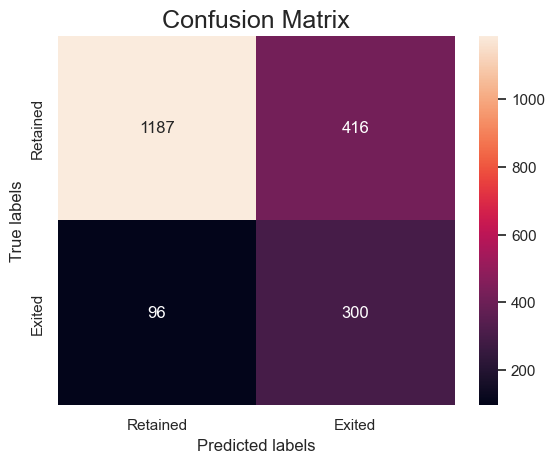

In [575]:
y_pred = logreg_best.predict(X_test_transformed)

cm = confusion_matrix(y_test,y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Retained', 'Exited']); ax.yaxis.set_ticklabels(['Retained', 'Exited']);

we focus to the recall score so based on that we can see from testing data and we can see if we can predict 297 customers with 99 customers wrong pred

In [589]:
### Feature Importance

coef = logreg_best.coef_[0]
fi = pd.DataFrame(data=coef, columns=["value"], index=X_test_transformed.columns)

fi['abs_value'] = fi['value'].abs()
fi = fi.sort_values(by="abs_value")

In [592]:
fi.sort_values(by="abs_value", ascending=False).head(5)

,value,abs_value
log__Age,2.711392,2.711392
cat__NumOfProducts_2,-1.396072,1.396072
cat__NumOfProducts_3,0.878920,0.878920
cat__IsActiveMember_1,-0.708231,0.708231
cat__Geography_Germany,0.653475,0.653475


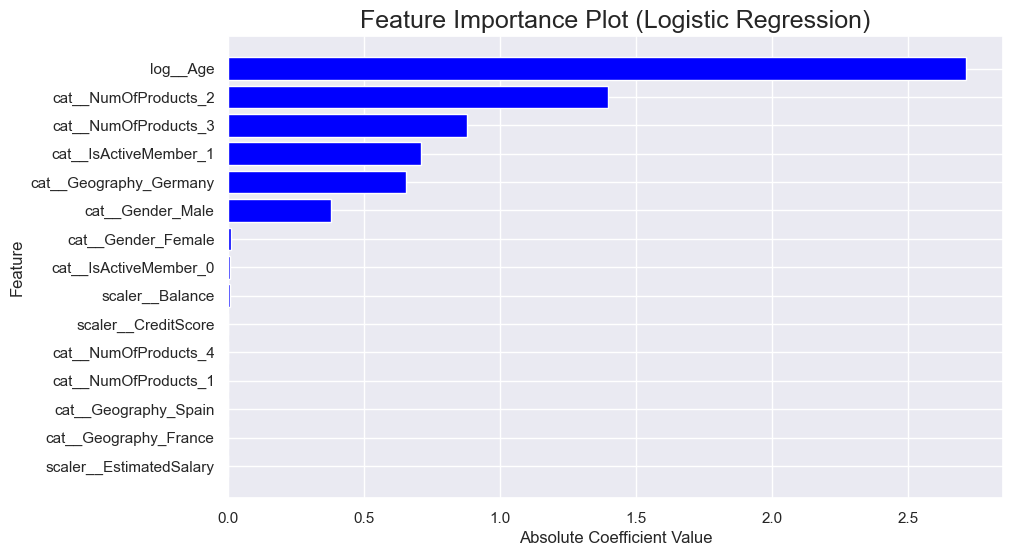

In [591]:
plt.figure(figsize=(10, 6))
plt.barh(fi.index, fi["abs_value"], color='blue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance Plot (Logistic Regression)')
plt.show()


##### Result #####


Based on the result of the model we get the following results:

Logistic Regression: 0.76 which from confusion_matrix we can see that the model is able to predict 76% or 300 custoemers who are likely to churn from 396 total customer churn. 
it means we can reduce the churn rate from around **20%** (396/1999) to **4.8%** ( 96/1999)

Based on the feature importance plot, we can see that the most important features are age,number of products, geography and gender. This is consistent with the EDA we did earlier, where we saw that the distribution of these features were different for the two classes. 